## HOMEWORK 4  ADM
### 2.1: Getting your data + feature engineering

##### 2.1.1: Accessing to the dataset

In [227]:
import pandas as pd
import numpy as np

#Reading the original dataset of Kaggle
path = r"C:\Users\sofyc\OneDrive\Desktop\Homework4_adm\df_uk_movies.csv"
df = pd.read_csv(path)

#General info
print(df.shape) #dimensions
print(df.columns) #names of the columns
df.head()

(671736, 8)
Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')


,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [228]:
#Control about the NaNs values in the columns
print(df['user_id'].isna().sum()) #0
print(df['title'].isna().sum()) #0
print(df['movie_id'].isna().sum()) #0
print(df['genres'].isna().sum()) #0
print(df['datetime'].isna().sum()) #0
print(df['release_date'].isna().sum()) #0
print(df['duration'].isna().sum()) #0

#Just to be sure
df=df.dropna(subset=['user_id'])

0
0
0
0
0
0
0


#### 2.1.2: Feature engineering of the first 5 variables

In [229]:
#To be sure that the columns 'datetime' and 'release_date' are in the correct forms
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

#Creating the variables:
#a) Favourite genre (i.e., the genre on which the user spent the most time)
df = df.assign(genres = df['genres'].str.split(',')).explode('genres') #There are more genres in a row
fav_genre = df.groupby('user_id')['genres'].agg(lambda x: x.value_counts().idxmax())

#b) Average click duration
avg_duration = df.groupby('user_id')['duration'].mean()

#c) Time of the day when the user spends the most time on the platform
#The modalities are: 1 for "Morning", 2 for "Afternoon", 3 for "Night"
df['hourofday'] = 0
df['hourofday'] = df.datetime.dt.hour #Taking just the hour
conditions = [
   (df['hourofday'] >= 0) & (df['hourofday'] < 12), # Morning
   (df['hourofday'] >= 12) & (df['hourofday'] < 18), # Afternoon
   (df['hourofday'] >= 18) & (df['hourofday'] <= 24) # Night
]

choices = [1, 2, 3]

df['hourofday'] = np.select(conditions, choices, default='Invalid')
time_day = df.groupby('user_id')['hourofday'].agg(lambda x: x.value_counts().idxmax())

#d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?
#The modalities are: 1 for "Old movie lover" and 2 for "Recent movie lover"
df['release_category'] = np.where(df['release_date'].dt.year < 2010, 1, 2)
movie_pref = df.groupby('user_id')['release_category'].agg(lambda x: x.value_counts().idxmax())

#e) Average time spent a day by the user
#.dt.date to consider just the date and not the time
avg_daily = df.groupby(['user_id', df['datetime'].dt.date])['duration'].sum().groupby('user_id').mean()


In [230]:
#New resulting dataframe
new_df = pd.DataFrame({
    'Favourite Genre': fav_genre,
    'Average Click Duration': avg_duration,
    'Time of Day': time_day,
    'Movie Preference': movie_pref,
    'Average Time per Day': avg_daily
})

#Assigning the index to a column
new_df['user_id'] = new_df.index
#Removing the index
new_df = new_df.reset_index(drop=True)

#Trasforming the column 'Average Click Duration' in minutes
new_df['Average Click Duration'] = (new_df['Average Click Duration'] / 60).round(2)
#Trasforming the column 'Average Time per Day' in minutes
new_df['Average Time per Day'] = (new_df['Average Time per Day'] / 60).round(2)

#Final dataset
new_df #161918 rows x 6 columns

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id
0,Crime,0.00,3,1,0.00,00004e2862
1,Thriller,36.92,3,2,339.64,000052a0a0
2,Mystery,0.00,3,2,0.00,000090e7c8
3,NOT AVAILABLE,-0.00,1,2,-0.01,000118a755
4,Drama,161.06,3,2,2576.90,000296842d
...,...,...,...,...,...,...
161913,Documentary,141.58,3,2,424.75,fffd9bf758
161914,Drama,29.75,2,2,89.25,fffe7b777b
161915,Documentary,656.02,3,2,1968.08,fffeac83be
161916,Documentary,0.00,2,1,0.00,ffff2c5f9e


#### 2.1.3: Feature engineering of the others 10 variables

In [231]:
#1) Most frequent day of week
df['day'] = df['datetime'].dt.day_name()  #Taking just the day

#Mapping the days of the week with numbers: 1 for Monday, 2 for Tuesday, 3 for Wednesday, 4 for Thursday, 5 for Friday, 6 for Saturday, 7 for Sunday
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

#Finding the most frequent day for every user in the numeric form
day_freq = df.groupby('user_id')['day'].agg(lambda x: x.map(day_mapping).value_counts().idxmax())

#Adding the column 'Frequent day' to new_df
new_df['Frequent day'] = new_df['user_id'].map(day_freq)


In [232]:
#2) Number of different genres clicked by the user
#This feature can be useful to understand the user's diverse interests.
df['genres_listo']= df['genres']
df = df.assign(genres_listo = df['genres_listo'].str.split(',')).explode('genres_listo') #There are more genres in a row
number_genre = df.groupby('user_id')['genres_listo'].nunique()

#Adding the column 'number_genres' to new_df
new_df['number_genres'] = new_df['user_id'].map(number_genre)

In [233]:
#3) Most frequent month
#Extracting the necessaries columns 
click_data = df[['user_id', 'datetime', 'duration']]

#Taking just the 'month'
click_data.loc[ :,'month'] = click_data['datetime'].dt.month

#Groupifying by 'user_id' and 'month' and then calculating the corrispondent sum of the 'duration'
user_monthly_duration = click_data.groupby(['user_id', 'month'])['duration'].sum().reset_index()

#Finding the most frequent month
user_most_frequent_month = user_monthly_duration.groupby('user_id')['month'].agg(lambda x: x.mode().iloc[0]).reset_index()

#Creating a DataFrame with 'user_id' and 'Frequent month'
user_most_frequent_month.columns = ['user_id', 'Frequent month']

#Adding the column 'Frequent month' to new_df
new_df = pd.merge(new_df, user_most_frequent_month, on='user_id', how='left')


C:\Users\sofyc\AppData\Local\Temp\ipykernel_10220\2352386759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  click_data.loc[ :,'month'] = click_data['datetime'].dt.month


In [234]:
#4) Number of total films watched per 'user_id'
total_films = df.groupby('user_id')['title'].nunique()

#Adding the column 'Total films' to new_df
new_df['Total films'] = new_df['user_id'].map(total_films)


In [235]:
#5) Frequency of clicks in the week (monday - thursday)
#Adding 2 columns to identify the day of the week and the type of the day
df['weekday'] = df['datetime'].dt.day_name()
df['weekend'] = df['datetime'].dt.dayofweek.isin([4, 5, 6])  #True if it is in the weekend, False otherwise

#Calculating the frequency of clicks between Monday and Thursday for every user
weekday_click_frequency = df[df['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])].groupby('user_id')['duration'].count().reset_index()
weekday_click_frequency.columns = ['user_id', 'Weekday Click Frequency']

#Adding the column 'Weekday Click Frequency' to new_df
new_df = pd.merge(new_df, weekday_click_frequency, on='user_id', how='left')

In [236]:
#6) Frequency of clicks in the weekend (Friday-Sunday)
weekend_click_frequency = df[df['weekend']].groupby('user_id')['duration'].count().reset_index()
weekend_click_frequency.columns = ['user_id', 'Weekend Click Frequency']

#Adding the column 'Weekend Click Frequency' to new_df
new_df = pd.merge(new_df, weekend_click_frequency, on='user_id', how='left')

In [237]:
#7) Year Duration Max

#First we find the Average time spent every year by the user
df['year'] = df['datetime'].dt.year #Taking just the year

#Calculating the sum of the duration for every year
yearly_duration = df.groupby(['user_id', 'year'])['duration'].sum().reset_index()

#Pivoting the data to have separated columns for every year.
#Transforming the dataset yearly_duration in a format where 'user_id' is the index.
#'year' becomes the name of the columns and the sum of the 'duration' is the value in the cells
avg_year_duration = yearly_duration.pivot(index='user_id', columns='year', values='duration').reset_index()

#Renominating the columns
avg_year_duration.columns = ['user_id', 'Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019']

#Adding the columns to new_df
new_df = pd.merge(new_df, avg_year_duration, on='user_id', how='left')

#Now that we have the 3 different columns (for every year), we take the max avg between the 3 for every user.
#We create another column with the corrispondent year with the max Avg Duration for every user.
#First the modalities are: 2017, 2018, 2019.
avg_year_columns = avg_year_duration[['Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019']]

#Finding the year with the max avg
max_year = avg_year_columns.apply(lambda row: row.idxmax().split()[-1], axis=1)

#Adding the column 'Year Duration Max' to new_df
new_df['Year Duration Max']=max_year

#Mapping the modalities with dummies: 1 for 2017, 2 for 2018, 3 for 2019
year_mapping = {"2017": 1, "2018": 2, "2019": 3}

#Applying the new modalities to the column 'Year Duration Max'
new_df['Year Duration Max'] = new_df['Year Duration Max'].map(year_mapping)

#Final drop of 'Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019'
new_df = new_df.drop(['Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019'], axis=1)

In [238]:
#8) Days Since Last Click
#The last click till June 2019 (because the dataset has time range: January 2017 to June 2019, inclusive)
last_click = df[df['datetime'] <= '30-06-2019'].groupby('user_id')['datetime'].max().reset_index()
last_click.columns = ['user_id', 'Last Click DateTime']

#Adding the column 'Last Click DateTime' to new_df
new_df = pd.merge(new_df, last_click, on='user_id', how='left')

#Calculating the difference between the date from the last click and June 2019
new_df['Days Since Last Click'] = (pd.to_datetime('2019-06-30') - new_df['Last Click DateTime']).dt.days

#Final drop of the feature 'Last Click DateTime'
new_df=new_df.drop(['Last Click DateTime'], axis=1)

In [239]:
#9) Number of Films Before 2000
df['release_year'] = df['release_date'].dt.year

#Counting the number of films with release date before 2000 for every user
movies_before_00 = df[df['release_year'] < 2000].groupby('user_id')['release_year'].count().reset_index()
movies_before_00.columns = ['user_id', 'Number of Films Before 2000']

#Adding the column 'Number of Films Before 2000' to new_df
new_df = pd.merge(new_df, movies_before_00, on='user_id', how='left')


In [240]:
#10) Percentage of movies that the user watched for more than 30 minutes
#Create a binary column indicating whether the movie duration is more than 30 minutes
df['watched_more_than_30_minutes'] = df['duration'] > 1800

#Count the total number of movies watched by each user
total_movies_watched = df.groupby('user_id').size()

#Count the number of movies watched for more than 30 minutes by each user
movies_watched_more_than_30_minutes = df[df['watched_more_than_30_minutes']].groupby('user_id').size()

#Calculate the percentage of movies watched for more than 30 minutes for each user
percentage_movies_watched_more_than_30_minutes = (movies_watched_more_than_30_minutes / total_movies_watched) * 100

#Create a DataFrame with 'user_id' and 'percentage' columns
percentage_df = percentage_movies_watched_more_than_30_minutes.reset_index()
percentage_df.columns = ['user_id', 'percentage']

#Add the column 'percentage' to new_df
new_df = pd.merge(new_df, percentage_df, on='user_id', how='left')

In [241]:
#Printing the final new_df and general information:
print(new_df.columns)
print(new_df.shape)

new_df

Index(['Favourite Genre', 'Average Click Duration', 'Time of Day',
       'Movie Preference', 'Average Time per Day', 'user_id', 'Frequent day',
       'number_genres', 'Frequent month', 'Total films',
       'Weekday Click Frequency', 'Weekend Click Frequency',
       'Year Duration Max', 'Days Since Last Click',
       'Number of Films Before 2000', 'percentage'],
      dtype='object')
(161918, 16)


,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
0,Crime,0.00,3,1,0.00,00004e2862,2,3,12,1,3.0,NaN,1,571.0,NaN,NaN
1,Thriller,36.92,3,2,339.64,000052a0a0,7,19,5,11,35.0,57.0,1,733.0,15.0,36.956522
2,Mystery,0.00,3,2,0.00,000090e7c8,5,3,3,1,NaN,3.0,2,477.0,NaN,NaN
3,NOT AVAILABLE,-0.00,1,2,-0.01,000118a755,5,2,6,2,1.0,3.0,2,379.0,1.0,NaN
4,Drama,161.06,3,2,2576.90,000296842d,1,4,12,1,24.0,8.0,2,180.0,NaN,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,Documentary,141.58,3,2,424.75,fffd9bf758,3,3,6,1,3.0,NaN,1,738.0,NaN,100.000000
161914,Drama,29.75,2,2,89.25,fffe7b777b,6,3,8,1,NaN,3.0,1,679.0,NaN,NaN
161915,Documentary,656.02,3,2,1968.08,fffeac83be,3,12,8,10,19.0,5.0,1,647.0,1.0,75.000000
161916,Documentary,0.00,2,1,0.00,ffff2c5f9e,7,5,7,2,NaN,5.0,1,706.0,NaN,NaN


### 2.2: Choose your features (variables)!

##### Preliminar steps
Before reducing the dimensionality and normalize, it is necessary to control that there aren't any NaNs values for each feature. We decided to put 0 for the columns 'Weekday Click Frequency', 'Weekend Click Frequency', 'Number of Films Before 2000' and 'percentage'. For the column 'Days Since Last Click', since it doesn't make sense to put 0 and there were just 191 NaNs, we decided to eliminate these rows.

In [242]:
#Control about the NaN values
for i in new_df.columns:
    print(f'{i}', new_df[f'{i}'].isna().sum())

Favourite Genre 0
Average Click Duration 0
Time of Day 0
Movie Preference 0
Average Time per Day 0
user_id 0
Frequent day 0
number_genres 0
Frequent month 0
Total films 0
Weekday Click Frequency 53275
Weekend Click Frequency 52897
Year Duration Max 0
Days Since Last Click 191
Number of Films Before 2000 135794
percentage 67118


In [243]:
#Filling the NaN of the columns with 0
new_df['Weekday Click Frequency'] = new_df['Weekday Click Frequency'].fillna(0)
new_df['Weekend Click Frequency'] = new_df['Weekend Click Frequency'].fillna(0)
new_df['Number of Films Before 2000'] = new_df['Number of Films Before 2000'].fillna(0)
new_df['percentage'] = new_df['percentage'].fillna(0)

#Limitating the decimals of 'percentage'
new_df['percentage'] = new_df['percentage'].round(2)

#Dropping the NaNs in the column 'Days Since Last Click'
new_df = new_df.dropna(subset=['Days Since Last Click'])

Another important preliminar part is to verify that every categorical variable has to be a dummy variable. Since the unique variable that has not this format yet is 'Favourite Genre', we transform it and reduce the categories in a smaller number.

In [244]:
#Looking at the modalities of 'Favourite Genre'
print(new_df['Favourite Genre'].unique())

['Crime' ' Thriller' 'Mystery' 'NOT AVAILABLE' 'Drama' ' Drama' 'Comedy'
 'Animation' 'Action' 'Documentary' 'Horror' 'Adventure' 'Biography'
 ' Sci-Fi' ' Romance' ' Fantasy' ' Comedy' 'Romance' ' Adventure' ' Crime'
 'Sci-Fi' ' Family' 'Thriller' ' Horror' 'Fantasy' 'Western' ' War'
 ' Mystery' 'Family' ' History' 'Short' ' Sport' ' Music' 'Reality-TV'
 ' Western' 'Musical' ' Biography' 'History' 'Talk-Show' ' Action' 'Sport'
 ' Musical' 'Music' 'News' ' Film-Noir']


In [245]:
#Eliminating the rows that have not the genre specified
new_df = new_df[new_df['Favourite Genre'] != 'NOT AVAILABLE']

#Ridefinting smaller categories
categories={
    1: {'Animation'}, #Animation
    2: {'Drama', ' Drama', ' Romance', 'Romance', 'Biography', ' Biography'}, #Drama-Romance
    3: {'Comedy', ' Comedy', ' Family', 'Family'}, #Comedy
    4: {' Sci-Fi', 'Sci-Fi', 'Fantasy', ' Fantasy'}, #Science Fiction
    5: {'Action', 'Adventure', ' Adventure', ' Action', ' Western', 'Western'}, #Action-Adventure
    6: {' Thriller', 'Thriller'}, #Thriller
    7: {'Crime', 'Mystery', ' Crime', ' Mystery', ' Film-Noir'}, #Crime
    8: {'News', 'Talk-Show', 'Reality-TV', 'Sport', ' Sport'}, #TV Programme
    9: {' War', ' History', 'History'}, #Historical movie
    10: {' Musical', 'Music', 'Musical', ' Music'}, #Musical
    11: {'Documentary', 'Short'}, #Documentary
    12: {' Horror', 'Horror'} #Horror
}

genres = new_df['Favourite Genre'].unique()

categorized_genres = {}
for category, values in categories.items():
    categorized_genres[category] = set(filter(lambda x: x in values, genres))

def update_genre(genre):
    for new_genre, mappings in categories.items():
        if genre in mappings:
            return new_genre
    return(13)  #Assign to 13='Other' if not found in any category. It is just to be sure that every row is taken.

#Applying the custom function to update the genders
new_df.loc[:, 'Favourite Genre'] = new_df['Favourite Genre'].apply(update_genre)

Finally, to complete this preliminar part, we transform the columns of 'Weekday Click Frequency', 'Weekend Click Frequency' and 'Days Since Last Click' in integers. For the columns 'Average Click Duration' and 'Average Time per Day' we take the module beacuse of the values that are negative. ---> OR WE ELIINATE THEM ??

In [246]:
#Transforming the floats in integers
new_df['Weekday Click Frequency']= pd.to_numeric(new_df['Weekday Click Frequency'], errors='coerce').astype(int)
new_df['Weekend Click Frequency']= pd.to_numeric(new_df['Weekend Click Frequency'], errors='coerce').astype(int)
new_df['Days Since Last Click']= pd.to_numeric(new_df['Days Since Last Click'], errors='coerce').astype(int)
new_df['Number of Films Before 2000']= pd.to_numeric(new_df['Number of Films Before 2000'], errors='coerce').astype(int)

#Taking the modules
new_df['Average Click Duration'] = np.abs(new_df['Average Click Duration'])
new_df['Average Time per Day'] = np.abs(new_df['Average Time per Day'])


In [247]:
#Final dataset
new_df

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
0,7,0.00,3,1,0.00,00004e2862,2,3,12,1,3,0,1,571,0,0.00
1,6,36.92,3,2,339.64,000052a0a0,7,19,5,11,35,57,1,733,15,36.96
2,7,0.00,3,2,0.00,000090e7c8,5,3,3,1,0,3,2,477,0,0.00
4,2,161.06,3,2,2576.90,000296842d,1,4,12,1,24,8,2,180,0,25.00
5,2,398.21,3,2,929.17,0002aab109,3,4,5,3,3,4,1,783,0,28.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,11,141.58,3,2,424.75,fffd9bf758,3,3,6,1,3,0,1,738,0,100.00
161914,2,29.75,2,2,89.25,fffe7b777b,6,3,8,1,0,3,1,679,0,0.00
161915,11,656.02,3,2,1968.08,fffeac83be,3,12,8,10,19,5,1,647,1,75.00
161916,11,0.00,2,1,0.00,ffff2c5f9e,7,5,7,2,0,5,1,706,0,0.00


##### 2.2.1: Normalization
We decided to apply the Normalization to scale all the values of the quantitative variables between 0 and 1, so it is possible to compare the data and apply the method for reducing the dimensionality.

In [248]:
from sklearn.preprocessing import MinMaxScaler

#List of the quantitative variables
quantitative_variables = ['Average Click Duration', 'Average Time per Day', 'number_genres',
                           'Total films', 'Weekday Click Frequency', 'Weekend Click Frequency',
                           'Days Since Last Click', 'Number of Films Before 2000', 'percentage']

#Creating a Min-Max scaler
scaler = MinMaxScaler()

#Applying the normalizzation to the quantitative variables
new_df[quantitative_variables] = scaler.fit_transform(new_df[quantitative_variables])


In [249]:
#Reassaigning the indexes to make them consecutive after the eliminations
new_df.reset_index(drop=True, inplace=True)

#Final dataset
new_df

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
0,7,0.000000,3,1,0.000000,00004e2862,2,0.064516,12,0.000000,0.003382,0.000000,1,0.628163,0.000000,0.0000
1,6,0.000193,3,2,0.000364,000052a0a0,7,0.580645,5,0.048077,0.039459,0.050442,1,0.806381,0.079787,0.3696
2,7,0.000000,3,2,0.000000,000090e7c8,5,0.064516,3,0.000000,0.000000,0.002655,2,0.524752,0.000000,0.0000
3,2,0.000842,3,2,0.002759,000296842d,1,0.096774,12,0.000000,0.027057,0.007080,2,0.198020,0.000000,0.2500
4,2,0.002083,3,2,0.000995,0002aab109,3,0.096774,5,0.009615,0.003382,0.003540,1,0.861386,0.000000,0.2857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155843,11,0.000740,3,2,0.000455,fffd9bf758,3,0.064516,6,0.000000,0.003382,0.000000,1,0.811881,0.000000,1.0000
155844,2,0.000156,2,2,0.000096,fffe7b777b,6,0.064516,8,0.000000,0.000000,0.002655,1,0.746975,0.000000,0.0000
155845,11,0.003431,3,2,0.002108,fffeac83be,3,0.354839,8,0.043269,0.021421,0.004425,1,0.711771,0.005319,0.7500
155846,11,0.000000,2,1,0.000000,ffff2c5f9e,7,0.129032,7,0.004808,0.000000,0.004425,1,0.776678,0.000000,0.0000


##### 2.2.2: Dimensionality reduction

We chose the Factor Analysis for Mixed Data because we have qualitative (categorical) variables and quantitative variables. Since this method is a combination of PCA (for reducting the dimensionality of quantitative variables) and MCA techniques (for reducting the dimensionality of qualitative variables).

We can now apply the Factor Analysis for Mixed Data (FAMD).

The number of factors is equal to the number of variables in our dataset, but not all the factors are going to provide useful information about the common variance between the variables and are going to be significant. There are criterias to decide the number of factors: one is based on the amount of common variance the factors explain, and the other is about their eigenvalues. We have to select the number of factors that have eigenvalues greater than 1. To this, we do a plot of the factors and their eigenvalues. The second criteria we are going to use is looking at the cumulative explained variance explained by the factors. Since we have normalized the data, select the factors whose eigenvalues which explain more variance than a single observed variable.

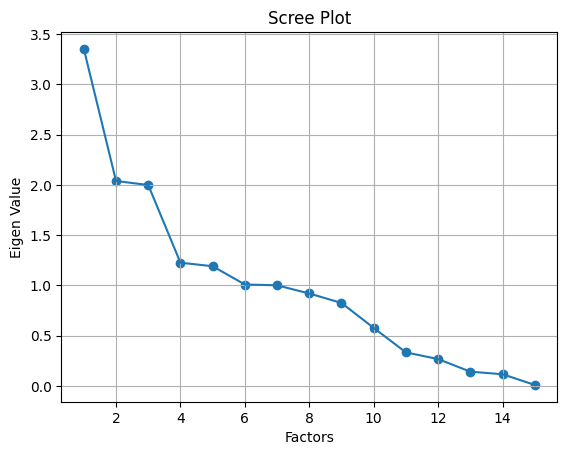

In [250]:
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

#Criteria 1
#Selecting the columns to include in the analysis of factors
columns_for_fa = ['Favourite Genre', 'Average Click Duration', 'Time of Day', 'Movie Preference', 'Average Time per Day', 'Frequent day', 'number_genres', 'Frequent month', 'Total films',
       'Weekday Click Frequency', 'Weekend Click Frequency', 'Year Duration Max', 'Days Since Last Click', 'Number of Films Before 2000', 'percentage']

#Creating a dataframe just with the selected columns
dataframe_for_fa = new_df[columns_for_fa]


#Copying the DataFrame
dataframe_for_fa_copy = dataframe_for_fa.copy()

#Substituting the infinites with NaN values
dataframe_for_fa_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

#Last checking of NaNs
dataframe_for_fa = dataframe_for_fa_copy.dropna()

#Inizialising the object FactorAnalyzer
fa = FactorAnalyzer(rotation=None, impute="drop")

#Fit of the analysis of the factors
fa.fit(dataframe_for_fa)

#Obtaining the eigenvalues
ev, _ = fa.get_eigenvalues()

#Visualising the Scree Plot
plt.scatter(range(1, len(ev) + 1), ev)
plt.plot(range(1, len(ev) + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()
plt.show()

From the graph we can see that the factors with eigenvalues greather than 1 are 6 or 7. Then to be sure about the number of factors, we see the precise values of the eigenvalues.

In [251]:
#Values of the eigenvalues
print(ev)

[3.35338261 2.03856855 1.99889538 1.22558189 1.19022686 1.00845195
 1.00064298 0.91892207 0.82484091 0.57635718 0.33278009 0.26615328
 0.14098258 0.11532129 0.00889238]


As it is possible to see, the factors that have eigenvalues greather than 1 are 7. Then it is confirmed the result of the plot.
Now we use the second criteria and then we compare them.

In [252]:
#Criteria 2
#Calculating the cumulative explained variance
cumulative_variance = np.cumsum(ev/15)
print(cumulative_variance)

[0.22355884 0.35946341 0.4927231  0.57442856 0.65377702 0.72100715
 0.78771668 0.84897815 0.90396755 0.94239136 0.9645767  0.98232025
 0.99171909 0.99940717 1.        ]


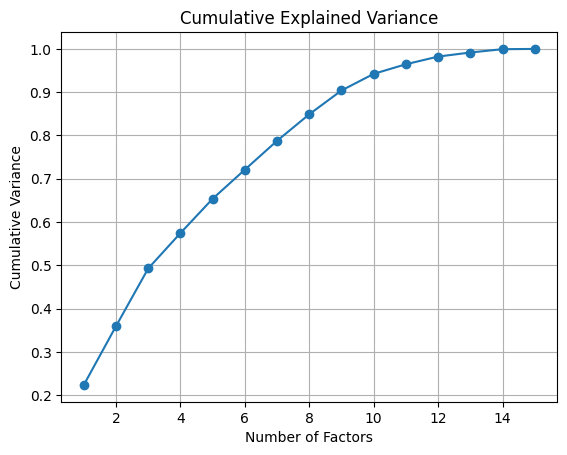

In [253]:
#Visualising the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Factors')
plt.ylabel('Cumulative Variance')
plt.grid()
plt.show()


From the second criteria we can see that 6 factors explain 72.1% of the variance, 7 factors 78.8% and 8 factors 84.9%. The optimal value is usually around 80%, but since the first criteria gave a result of 7 factors and the cumulative explained variance is 78.8%, we confirm 7 factors. Then we can find the final dataset with the 7 new features:

In [254]:
#Factor Analysis with 7 factors
fa = FactorAnalyzer(n_factors=7, rotation=None, impute="drop")
fa.fit(dataframe_for_fa)

#Obtaining the transformed data based on 7 factors
factors_data = fa.transform(dataframe_for_fa)

#Creating a new dataset with the 7 factors
columns_factors = [f'Factor_{i+1}' for i in range(7)]
df_factors = pd.DataFrame(data=factors_data, columns=columns_factors)

# Riporta l'indice originale a new_df_factors
df_factors.reset_index(drop=True, inplace=True)

#Adding the column 'user_id' to the new DataFrame with the factors
df_factors['user_id'] = new_df['user_id']

#Final dataset
df_factors

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,user_id
0,-0.600061,1.210708,-0.475202,-0.277647,1.268603,-1.267220,-0.491524,00004e2862
1,2.855487,1.048308,-0.120705,0.379667,0.529839,1.452321,-2.234614,000052a0a0
2,-0.553746,-0.155724,-0.276230,1.021073,-0.089074,0.556295,-0.065641,000090e7c8
3,-0.181540,-0.140007,-0.197540,-1.672055,0.406808,-2.056430,0.326910,000296842d
4,-0.065842,1.182625,-0.234080,-0.123846,-1.254067,-0.027980,0.517676,0002aab109
...,...,...,...,...,...,...,...,...
155843,-0.615313,1.159702,-0.397495,1.884656,0.975033,-0.386719,-0.125581,fffd9bf758
155844,-0.436505,1.166684,-0.383602,-0.915285,-0.371453,0.629496,0.336129,fffe7b777b
155845,1.141876,1.051817,-0.141069,1.626585,1.736147,-0.968358,0.472889,fffeac83be
155846,-0.396322,1.141332,-0.430909,1.390781,1.600394,0.912156,-0.715034,ffff2c5f9e


##### Interpretation of the Factors
For the interpretation of the Factors, first we see their weights respect to the original variables.

In [289]:
#Fctors' Weights
factor_weights = fa.loadings_.T


#Selecting the weights of the Factor 1
weights_factor_1 = factor_weights[0]
#Obtaining the original variables with the highest weghts for Factor 1
top_variables_factor_1 = dataframe_for_fa.columns[np.abs(weights_factor_1).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 1
print(f"Variables influenced by Factor 1: {top_variables_factor_1}")

#Selecting the weights of the Factor 2
weights_factor_2 = factor_weights[1]
#Obtaining the original variables with the highest weghts for Factor 2
top_variables_factor_2 = dataframe_for_fa.columns[np.abs(weights_factor_2).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 2
print(f"Variables influenced by Factor 2: {top_variables_factor_2}")

#Selecting the weights of the Factor 3
weights_factor_3 = factor_weights[2]
#Obtaining the original variables with the highest weghts for Factor 3
top_variables_factor_3 = dataframe_for_fa.columns[np.abs(weights_factor_3).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 3
print(f"Variables influenced by Factor 3: {top_variables_factor_3}")

#Selecting the weights of the Factor 4
weights_factor_4 = factor_weights[3]
#Obtaining the original variables with the highest weghts for Factor 4
top_variables_factor_4 = dataframe_for_fa.columns[np.abs(weights_factor_4).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 4
print(f"Variables influenced by Factor 4: {top_variables_factor_4}")

#Selecting the weights of the Factor 5
weights_factor_5 = factor_weights[4]
#Obtaining the original variables with the highest weghts for Factor 5
top_variables_factor_5 = dataframe_for_fa.columns[np.abs(weights_factor_5).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 5
print(f"Variables influenced by Factor 5: {top_variables_factor_5}")

#Selecting the weights of the Factor 6
weights_factor_6 = factor_weights[5]
#Obtaining the original variables with the highest weghts for Factor 6
top_variables_factor_6 = dataframe_for_fa.columns[np.abs(weights_factor_6).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 6
print(f"Variables influenced by Factor 6: {top_variables_factor_6}")

#Selecting the weights of the Factor 7
weights_factor_7 = factor_weights[6]
#Obtaining the original variables with the highest weghts for Factor 7
top_variables_factor_7 = dataframe_for_fa.columns[np.abs(weights_factor_7).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 7
print(f"Variables influenced by Factor 7: {top_variables_factor_7}")


Variables influenced by Factor 1: Index(['Total films', 'Weekday Click Frequency', 'Weekend Click Frequency'], dtype='object')
Variables influenced by Factor 2: Index(['Year Duration Max', 'Days Since Last Click', 'Frequent month'], dtype='object')
Variables influenced by Factor 3: Index(['Average Click Duration', 'Average Time per Day', 'percentage'], dtype='object')
Variables influenced by Factor 4: Index(['Favourite Genre', 'Frequent month', 'Days Since Last Click'], dtype='object')
Variables influenced by Factor 5: Index(['Frequent month', 'Favourite Genre', 'Days Since Last Click'], dtype='object')
Variables influenced by Factor 6: Index(['Frequent day', 'Weekday Click Frequency', 'Weekend Click Frequency'], dtype='object')
Variables influenced by Factor 7: Index(['Number of Films Before 2000', 'Movie Preference', 'Favourite Genre'], dtype='object')


We can visualize the correlations between the Factors and the features of new_df.

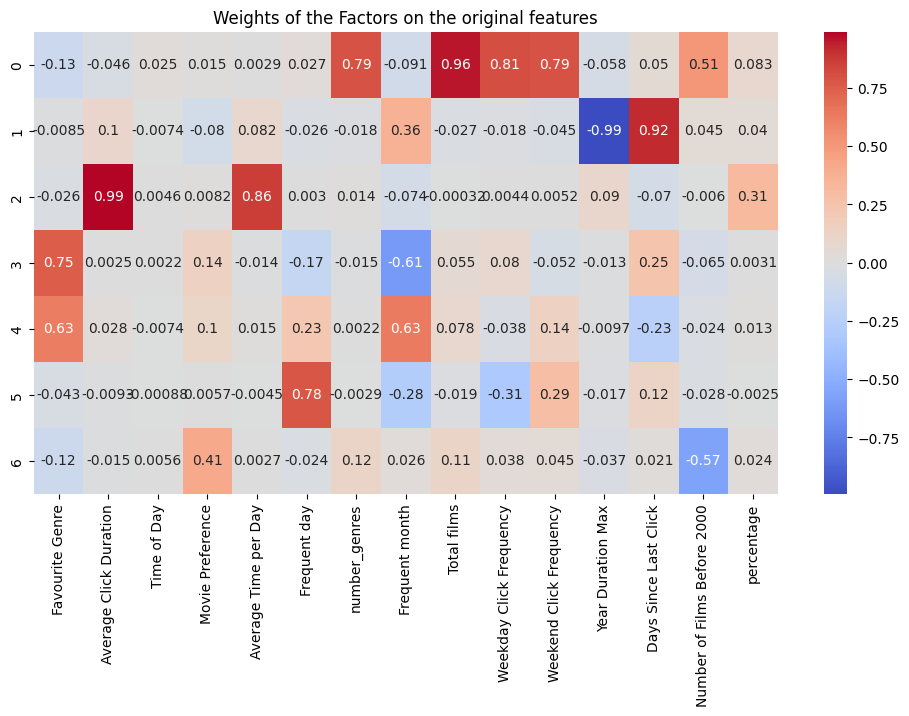

In [291]:
#Heatmap: correlations between factors and the original features
plt.figure(figsize=(12, 6))
sns.heatmap(factor_weights, annot=True, xticklabels=dataframe_for_fa.columns, cmap='coolwarm')
plt.title('Weights of the Factors on the original features')
plt.show()

Note: in the Heatmap thue Factors go from 0 to 6, but we define them from 1 to 7.

From the Heatmap we can say that:
- Factor 1 is positive influenced by 'Total Films', 'Weekday Click Frequency', 'Weekend Click Frequency' and 'number_genres', so to the increase of of the number of films, corresponds an increase of the other variables;
- Factor 2 is negative correlated with 'Year Duration Max' and positive correlated to 'Days since last click', then the more is the number of days since last click, the less is the year with the maximum average duration ('Year Duration Max' is a dummy that represent the years 2017, 2018, 2019);
- Factor 3 shows a positive correlation with 'Average Click Duration' and 'Average Time per Day', then to the average duration of a click corresponds an average daily time;
- Factor 4 is positve correlated to 'Favourite Genre' and negative correlated to 'Frequent month';
- Factor 5 has the same positive correlation with 'Favourite Genre' and 'Frequent month';
- Factor 6 has a positive correlation with 'Frequent day'. For this factor it is interesting to notice that this factor has a low negative correlation with 'Weekday Click Frequency' and a low positive correlation with 'Weekend Click Frequency', then to the increase of this factor for a certain user corresponds a higher frequency of the clicks during the weekend;
- Factor 7 is low positive correlated to 'Movie Preference' and negative correlated to 'Number of Films Before 2000', since the variable about preference of the movies has the modalities 1 for "Old movie lover" (before 2010) and 2 for "Recent movie lover". Then, the bigger is the number of films realized before 2000 seen by a certain user, the lower is the preference.

### 2.3 Clustering!

### 2.3.1: Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce
Constructing the algorithm is a lot easier with an input(our data set we received after the dimensionality reductionp), this is why 2.3.1 and 2.3.3 are solved in one step. The algorithm will be called again later on with the optimal cluster size.
First we have to import the necessary libraries.

In [255]:
#Libraries for the visulaization of our clusters
from sklearn.decomposition import PCA
from IPython.display import clear_output

#Library for scaling the dataframe
from sklearn.preprocessing import StandardScaler

In [256]:
data = df_factors.drop('user_id', axis=1)
data

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
0,-0.600061,1.210708,-0.475202,-0.277647,1.268603,-1.267220,-0.491524
1,2.855487,1.048308,-0.120705,0.379667,0.529839,1.452321,-2.234614
2,-0.553746,-0.155724,-0.276230,1.021073,-0.089074,0.556295,-0.065641
3,-0.181540,-0.140007,-0.197540,-1.672055,0.406808,-2.056430,0.326910
4,-0.065842,1.182625,-0.234080,-0.123846,-1.254067,-0.027980,0.517676
...,...,...,...,...,...,...,...
155843,-0.615313,1.159702,-0.397495,1.884656,0.975033,-0.386719,-0.125581
155844,-0.436505,1.166684,-0.383602,-0.915285,-0.371453,0.629496,0.336129
155845,1.141876,1.051817,-0.141069,1.626585,1.736147,-0.968358,0.472889
155846,-0.396322,1.141332,-0.430909,1.390781,1.600394,0.912156,-0.715034


As we will be dealing with distances, we have to scale our data, in order to avoid, that some features have a bigger influence than others. It standardizes the features indepently by removing the mean and scaling to unit variance.

In [257]:
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)
data = pd.DataFrame(scaled, columns=data.columns)

We write a function that selects our first centroids randomly. This is done by just picking some datapoints. This function will return a dataframe. We want the centroids to be columns, so we transpose the dataframe before returning it.

In [258]:
# Randomly select centroids from the dataset
def random_centroids(data, k):
    centroids=data.sample(k)
    return centroids.T

We write our map function. This function will return the index of the closest centroid for each datapoint as a pandas series

In [259]:
#Map function
def mapping(data, centroids):
    #Calculates the squared distance of every centroid with every datapoint
    distances = centroids.apply(lambda x: (((data-x)**2)).sum(axis=1))
    #returns the index of the closest cluster for every datapoint
    return distances.idxmin(axis=1)

Now we write our reduce function. It reallocates the centroids to the positon, that minimizes the distances of the datapoints that were assigned to the respective centroid.This function returns a dataframe, that is again transpozed as we want the centroids to be columns.

In [260]:
#Reduce Function
def reduce(data, clusters, k):
    #groups the data by the clusters from the map function and calculates the arithmetic mean for each of these groups
    return data.groupby(clusters).apply(lambda x: x.mean()).T

The next step is not a an actual part of an algorithm, but as we want to visualize our results, in order to see if they are reasonable, we write another function to plot our clusters. We do this by making our data two dimensional.
The title of our plot is the current iteration, as we write the function in a way that it displays our clusters for each iteration, in order to see if the development makes sense.

In [261]:
#Visualizing plots
def plot_clusters(data, clusters, centroids, iteration):
    #Initializing our PCA with 2 columns
    pca= PCA(n_components= 2)
    #Fit and transform our data to two dimensions
    data_2d= pca.fit_transform(data)
    #Fit and transform our centroids to two dimensions, we have to transform the dataframe, because the PCA expects the cnetroids to be rows
    centroids_2d= pca.transform(centroids.T)
    #Output is cleared after every iteration, so new output can be shown
    clear_output(wait= True)
    #Set title
    plt.title(f' Iteration {iteration}')
    #Plot each datapoint to our graph and colour it according to clusters
    plt.scatter(x=data_2d[:,0], y= data_2d[:,1], c=clusters)
    #Plot the centroids to our graph
    plt.scatter(x=centroids_2d[:,0], y= centroids_2d[:,1], c='red')
    #Show the plot
    plt.show()
    

Now we have all the functions we need to pull our algorithm together. The first centroids are chosen randomly(random_centroids function). Afterwards each datapoint is assgined to a cluster(mapping function) and the new centroids of that clusters are getting computed(reduce function). This process is being repeated until the the centroids don't change anymore or the max_iterations criteria is met to avoid an infinte loop.The result of every iteration is always getting visualized(plot_clusters function) The number of the max_iterations is chosen arbitrarily, as well as the number of k(number of clusters). We just want to check if our algorithm is working.

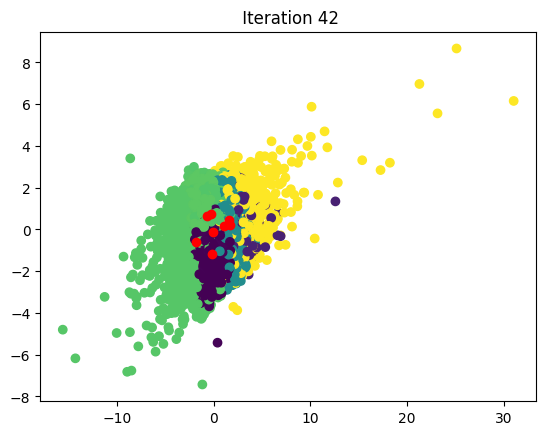

In [262]:
#criteria to break the loop
max_iterations= 100
#number of clusters
k=8
#We ranndomly choose our first centroids
centroids= random_centroids(data, k)
#Initialization of an empty dataframe to store the previous centroids
old_centroids= pd.DataFrame()
#Initialization of iteration count
iteration=1

#loop
while iteration < max_iterations and not centroids.equals(old_centroids):
    #old centroids are getting assigned
    old_centroids= centroids.copy()
    #Map
    clusters= mapping(data, centroids)
    #Reduce
    centroids= reduce(data, clusters, k)
    #Visualization
    plot_clusters(data, clusters, centroids, iteration)
    #Adjusting counter
    iteration+=1

TO DO: Interpreation of result

#### 2.3.2: Find an optimal number of clusters
For this part we decided to use two methods: Elbow method and silhouette method.

##### Elbow method
The elbow method works a follows: We first define a possible range for the possible number of clusters(in our case 1 to 15). For each number of clusters the initial centroids are chosen randomly and the SSE is being computed by applying the Kmeans algorithm from the sklearn library. This will be repeated for a predefined amount of times (in our case 10) and only the smallest SSE value for the specific number of clusters is returned. Afterwards we have a list of SSE's for the different numbers of clusters and plot the against each other. Then we have to visually evaluate which is the perfect cluster size. The optimal cluster size is the one, where a bend in the slope(elbow) can be seen. As the evaluation is visual, it only works well for data that is well clustered and the bend can be easily identified.

In [263]:
from sklearn.cluster import KMeans

In [264]:
kmeans_paras = {
  "init": "random", #The initial centroids are chosen randomly
  "n_init": 15, #K-means algorithm is run 10 times with different centroids, the centroids with the smallest number of SSE are returned
  "random_state": 1, #Ensures the reproducibility of results
}

In [265]:
#Initialize a list of SSE's
sse = []
#Loop over different amounts of clusters. In this example: 1 to 15
for k in range(1, 16): 
    #Create a k-means object
    kmeans = KMeans(n_clusters=k, **kmeans_paras)
    #Fit the k-means object to the data
    kmeans.fit(data)
    #Appends the SSE to the list
    sse.append(kmeans.inertia_)

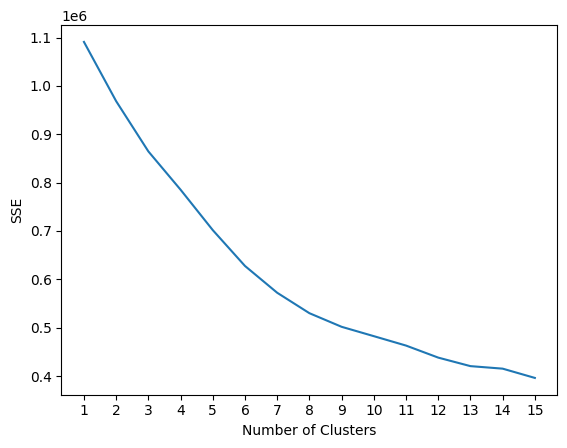

In [266]:
#Visualising
#Plot the SSE values against the number of clusters
plt.plot(range(1, 16), sse)
plt.xticks(range(1, 16))
#Name the x-/ and y-achsis
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
#Show the plot
plt.show()

We really have problems identifying the 'elbow'. It could be at 7,8 or 9 --> ????

##### Silhouette method
Now we are going to use the Silhouette method. It works as follows: We first define a possible range for the possible number of clusters(in our case 1 to 15). For each number of clusters the initial centroids are chosen randomly and the SSE is being computed by applying the Kmeans algorithm from the sklearn library.This will be repeated for a predefined amount of times (in our case 10) and for the smallest SSE value for the specific number of clusters the Sihlouette score gets computed.The Silhouette score is a ratio of how similar a sample is to its own cluster compared to other clusters. It ranges from -1 to 1 and indicates how well clustered the data is. The sihlouette scores are stored in a dictionnary as values with the corresponding  number of clusters as key. To find the optimal number of clusters we have to extract the key of the highest score from the dictionnary.

In [267]:
from sklearn.metrics import silhouette_score

In [268]:
kmeans_paras = {
 "init": "random", #The initial centroids are chosen randomly
 "n_init": 15, #K-means algorithm is run 10 times with different centroids, the centroids with the smallest number of SSE are returned
 "random_state": 1, #Ensures the reproducibility of results
}

In [269]:
#Initialize the dictionnary
silhouette_scores = {}
#Loop over different amounts of clusters. In this example: 1 to 15
for k in range(2, 16):
    #Create a k-means object
    kmeans = KMeans(n_clusters=k, **kmeans_paras)
    #Fit the k-means object to the data
    kmeans.fit(data)
    #Calculates the Silhouette score
    score = silhouette_score(data, kmeans.labels_)
    # Stores the sihlouette score with the number of clusters as key in a dictionnary
    silhouette_scores[k] = score
    print(score)

0.15076100742485088
0.17782759701918627
0.18717153456651472
0.18665545149787546
0.19899175425793034
0.2066368126310924
0.20616166148843248
0.19969124563932397
0.20099898895205873
0.19759238690829953
0.19855801104562612
0.20302767168674213
0.19980607774281864
0.20232687208156966


In [270]:
#Extract the number of clusters with the highest score
optimal_k = max(silhouette_scores, key=silhouette_scores.get)

#Final results
optimal_k

7

According to the Silhouette score our optimal cluster size is 7.

The evaluate the optimal amount of clusters we decide to go with the Sihlouette method. We do this mainly for the reason, that we can can perfectly see the weakness of the elbow method in our case. Our clusters are quite weak, which is also displayed by the low sihlouette scores we get. This means that it is really hard to visually find the
'elbow' in our plot. It could be argued, that it is also at a cluster size of seven, but can't be clearly evaluated. The disadvantage of the Silhouette score is, that it has a way longer running time than the elbow method.

Now we run our k-means algorithm as well with the optimal cluster size of 7.

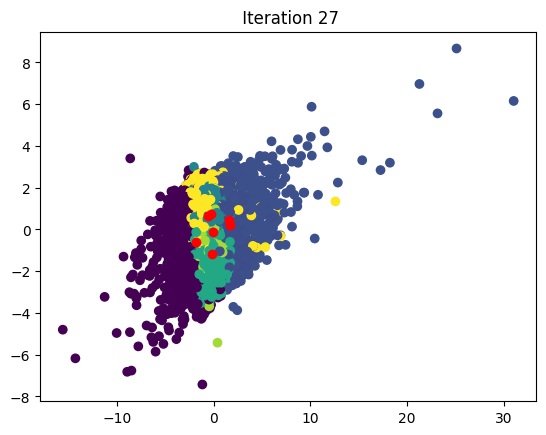

In [271]:
#criteria to break the loop
max_iterations= 100
#number of clusters
k=7
#We ranndomly choose our first centroids
centroids= random_centroids(data, k)
#Initialization of an empty dataframe to store the previous centroids
old_centroids= pd.DataFrame()
#Initialization of iteration count
iteration=1

#loop
while iteration < max_iterations and not centroids.equals(old_centroids):
    #old centroids are getting assigned
    old_centroids= centroids.copy()
    #Map
    clusters= mapping(data, centroids)
    #Reduce
    centroids= reduce(data, clusters, k)
    #Visualization
    plot_clusters(data, clusters, centroids, iteration)
    #Adjusting counter
    iteration+=1

#### 2.3.4:Implement K-means++ from scratch and explain the differences with the results you got earlier.

The K-means++ algorithm differs from the k-means algorithm in the way the initial centroids are chosen. Instead of choosing all the initial centroids randomly, this is only done for the first one. Afterwards the datapoints get weights that are proportional to the distance to the nearest centroid. The next centroid is then chosen (randomly) with respect to the probabilities. This makes the algorithm way more efficient.

In order to write the new random_centroids function, which creates the initial centroids, we have to first write two helping functions

The first helping function calculates the squared distance between a centroid and each datapoint. It returns a pandas series.

In [272]:
def calco_distances(centroid, data):
    distances = data.apply( lambda row : ((centroid-row)**2).sum(axis=1), axis=1)
    #distances = data.apply(lambda row: np.sum((centroid - row)**2), axis=1)
    return distances

The next helping function chooses the next centroid by choosing random with respect to the probabilities that are proprotional to the distance to the nearest centroid.

In [273]:
def get_centroid(distances):
    #Assigning the weights for the probabilities: They get assigned the distance. The reshape is necessary as they were a list of lists before which was not compatible with the random choice function
    weights = distances.to_numpy().reshape(-1)
    #Get new centroid with respect to probabilities. probabilitiy= distance/ sum of all distances
    centroid = np.random.choice( np.arange(0,len(data)), p=weights/sum(weights))
    #We return centroid as a dataframe and transpose it 
    return pd.DataFrame(data.iloc[centroid,]).T

Now we have our helping functions and we can pull the new random_centroid function together.

In [274]:
def random_centroids(data, k):
    #We initialize dataframes to store our centroids and distances
    centroids= pd.DataFrame()
    df_distances = pd.DataFrame()
    #We loop over the number of needed centroids
    for i in range(k):
        # if condition for creation of first centroid
        if len(centroids) == 0:
            #randomly choose a datapoint as first centroid
            centroid = data.sample(n=1).copy()
        #else condition, that always gets entered after the first centroid was created
        else:
            distances = df_distances.min(axis=1)
            centroid = get_centroid(distances)
        centroids = pd.concat([centroids, centroid])
        # creating a column in our df_distances dataframe that stores the distances of each datapoint to the respective centroid
        df_distances[str(i)] = calco_distances(centroid, data)
    return centroids.T

Besides the new function to create the initial centroids, the other functions remain the same as for the k-means algorithms. Therefor there won't be any further comments on them.

In [275]:
#Map function
def mapping(data, centroids):
    #Calculates the squared distance of every row with every datapoint
    distances = centroids.apply(lambda x: (((data-x)**2)).sum(axis=1))
    #returns the index of the closest cluster for every datapoint
    return distances.idxmin(axis=1)

In [276]:
#Reduce Function
def reduce(data, clusters, k):
    #groups the data by the clusters from the map function and calculates the arithmetic mean for each of these groups
    return data.groupby(clusters).apply(lambda x: x.mean()).T

In [277]:
#Visualize plots
def plot_clusters(data, clusters, centroids, iteration):
    #Initializing our PCA with 2 columns
    pca= PCA(n_components= 2)
    #Fit and transform our data to two dimensions
    data_2d= pca.fit_transform(data)
    #Fit and transform our centroids to two dimensions, we have to transform the dataframe, because the PCA expects the cnetroids to be rows
    centroids_2d= pca.transform(centroids.T)
    #Output is cleared after every iteration, so new output can be shown
    clear_output(wait= True)
    #Set title
    plt.title(f' Iteration {iteration}')
    #Plot each datapoint to our graph and colour it according to clusters
    plt.scatter(x=data_2d[:,0], y= data_2d[:,1], c=clusters)
    #Plot the centroids to our graph
    plt.scatter(x=centroids_2d[:,0], y= centroids_2d[:,1], c='red')
    #Show the plot
    plt.show()

Now we run our K++ means algorithm.

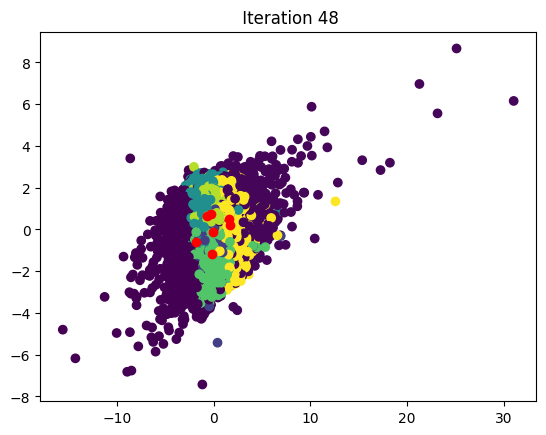

In [278]:
max_iterations= 100
k=7
centroids= random_centroids(data, k)
old_centroids= pd.DataFrame()
iteration=1
while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids= centroids
    
    clusters= mapping(data, centroids)
    centroids= reduce(data, clusters, k)
    plot_clusters(data, clusters, centroids, iteration)
    iteration+=1

We can't see a significant difference in the clustering compared to the K-means algorithm, which is very likely due to the fact that our data is not suitable for partitional clustering.

#### 2.3.5: Other clustering from ChatGPT
Here is the implemantation of Chat GPT, adjusted to our data:

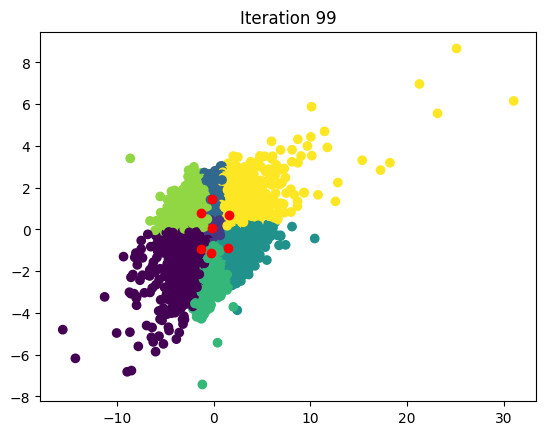

In [279]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Fit PCA on the original data
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(data_2d)

# Fit PCA on the cluster centers
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)

for iteration in range(100):
   clear_output(wait=True)
   plt.title(f'Iteration {iteration}')
   plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=kmeans.labels_)
   plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], c='red')
   plt.show()

#### 2.4: Analysing your results!

#### 3: Bonus Question

The suggestions from CHATGPT are these three:
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise): it identifies clusters with arbitrary shapes, detects clusters surrounded or overlapped by other clusters, makes sense of noise, it is good for anomaly detection (robust to outliers) and it doesn't require to specify the total number of clusters.
- OPTICS (Ordering Points to Identify Clustering Structure): it's about extracting the clustering structure of a dataset by identifying the density-connected points. It is connected to the concept of reachability distance, which measures the density at a particular point and its ability to reach other points.
- HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise): it has a hierarchical approach to clustering and it builds a cluster hierarchy.

We decided for the firt one, the DBSCAN, since it doesn't require to specify the number of clusters.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Taking the columns of the factors (removing 'user_id')
mydata = df_factors.drop('user_id', axis=1).values

#Defining the parameters to explore
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = np.arange(1, 10)

best_silhouette_score = -1
best_eps = None
best_min_samples = None

#Trying different values of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(mydata)
        
        #Calculating the silhouette
        silhouette_avg = silhouette_score(mydata, cluster_labels)
        
        #New best parameters
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_eps = eps
            best_min_samples = min_samples

#Visualizing the best parameters
print("Best parameters:")
print(f"eps: {best_eps}")
print(f"min_samples: {best_min_samples}")
print(f"Best score of silhouette: {best_silhouette_score}")

#Training the DBSCAN model with the best parameters
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_cluster_labels = best_dbscan.fit_predict(mydata)

#Plot with the final results
sns.scatterplot(x=mydata[:, 0], y=mydata[:, 1], hue=best_cluster_labels, palette='viridis')
plt.title(f'Results of the Clustering with DBSCAN (eps={best_eps}, min_samples={best_min_samples})')
plt.show()


KeyboardInterrupt: 